### Лабораторная работа №4: Деревья решений 
##### Выполнил студент группы: 6131-010402D Павлов Владислав

### 1. Загрузка датасета

In [47]:
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

In [48]:
df = pd.read_csv("big_dataset.csv")

### 2.1 Описание датасета 

#### Большой набор данных о мошенничестве с онлайн-платежами
#### Цель - определить тип транзакции мошенническая или обычная

| Признак | Описание | Единицы измерения |
|:-------:|:--------:|:-----------------:|
| step | Шаг | numerical |
| type | Тип онлайн-транзакции | categorical |
| amount | Сумма транзакции | numerical |
| nameOrig | Клиент, запускающий транзакцию | categorical |
| oldbalanceOrg | Баланс до транзакции | numerical |
| newbalanceOrig | Баланс после транзакции | numerical | 
| nameDest | Получатель транзакции | categorical |
| oldbalanceDest | Баланс получателя до транзакции | numerical |
| newbalanceDest | Баланс получателя после транзакции | numerical |
| isFraud | Мошенническая транзакция  | binary |
| isFlaggedFraud | Флаг транзакции | binary |

##### Целевой класс содержит два значения - 0 или 1, где 0 - обычная транзакция, 1 - мошенническая транзакция



In [49]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Так как датасет очень большой, возьму от исходного 1/80 часть 

In [51]:
df_length = len(df)
part = df_length // 80

part_df = df.sample(n = part)
print(part_df)

         step      type     amount     nameOrig  oldbalanceOrg  \
2935217   229   PAYMENT   18112.83     C9627765            0.0   
6345900   694   CASH_IN  163328.88  C1645782512        21988.0   
5307129   373   PAYMENT    6034.27  C1497256432            0.0   
2166897   185  CASH_OUT   14665.67  C1017872328        36571.0   
5378320   376  CASH_OUT  351810.86   C866448202        10028.0   
...       ...       ...        ...          ...            ...   
3681991   276   CASH_IN   98503.13  C2121805922        20293.0   
4444347   323  CASH_OUT  222264.11   C399086846            0.0   
6106376   525   PAYMENT   28597.15   C658492520        45030.0   
3858429   283   CASH_IN   98384.60  C1470703635          103.0   
1181036   132  CASH_OUT  415996.43  C1807244038            0.0   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
2935217            0.00  M1088658397            0.00            0.00        1   
6345900       185316.88  C1298369213       79

### 2.2 Предобработка данных

In [52]:
part_df.isna().any().any()

False

In [53]:
# Проверка на наличие null
part_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [54]:
columns_drop = ["step","nameOrig","nameDest", "isFlaggedFraud"]
df_dropped = part_df.drop(columns = columns_drop, axis= 1)


### 2.3 Кодировка категориальных признаков

In [55]:
unique_values = df_dropped["type"].unique()
print(unique_values)

['PAYMENT' 'CASH_IN' 'CASH_OUT' 'TRANSFER' 'DEBIT']


In [56]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_dropped["type"] = label_encoder.fit_transform(df_dropped["type"])
print(df_dropped["type"].head())


2935217    3
6345900    0
5307129    3
2166897    1
5378320    1
Name: type, dtype: int32


### 2.4 Нормализация данных

In [57]:
x = df_dropped.drop("isFraud", axis = 1)
y = df_dropped["isFraud"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled_df = pd.DataFrame(x_scaled, columns = x.columns)

In [58]:
x_scaled_df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0.958759,-0.230073,-0.289699,-0.293620,-0.319593,-0.316456
1,-1.266257,-0.030133,-0.282037,-0.229809,-0.089499,-0.154786
2,0.958759,-0.246703,-0.289699,-0.293620,-0.319593,-0.316456
3,-0.524585,-0.234819,-0.276956,-0.286077,0.180768,0.130026
4,-0.524585,0.229377,-0.286205,-0.293620,-0.319593,-0.226167


### 2.5 Разбивка выборки на обучающую и тестовую

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 42)

### 3. Дерево решений
#### 3.1 С использованием GridSearchCV осуществить подбор гиперпараметра DesicionTreeClassifier

In [60]:
grid = {
    'max_depth': range(1, x.shape[1]),
    'max_features': range(2, 20),
    'min_samples_leaf': range(5, 20)
}

model = DecisionTreeClassifier()

search = GridSearchCV(model, grid, cv = 5, n_jobs= -1, verbose = 2)
search.fit(x_train, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6), 'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)},
             verbose=2)

### 3.2 Вывести значение гиперпараметра и метрик для наилучшей модели DecisionTreeClassifier

In [61]:
search.best_params_

{'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 10}

In [62]:
best_model = search.best_estimator_
best_model_pred = best_model.predict(x_train)

In [63]:
tree_model_acc = accuracy_score(y_train, best_model_pred)
tree_model_prec = precision_score(y_train, best_model_pred)
tree_model_rec = recall_score(y_train, best_model_pred)
tree_model_f1 = f1_score(y_train, best_model_pred)

print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")

Accuracy: 0.7005855726397471; Precision: 0.6428571428571429; Recall: 0.003234888875576589; F1_score: 0.006437384514513918


### 3.3 Для получения наилучшего дерева вывести feature_importances, отсортировать по убыванию


In [64]:

feature_importances = best_model.feature_importances_

feature_importance_dict = {feature: importance for feature, importance in zip(x_train.columns, feature_importances)}

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Отсортированные значения feature_importances по убыванию:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Отсортированные значения feature_importances по убыванию:
oldbalanceOrg: 0.6933127258700214
amount: 0.23950373742332734
oldbalanceDest: 0.06718353670665145
type: 0.0
newbalanceOrig: 0.0
newbalanceDest: 0.0


### 3.4 Осуществить фильтрацию признаков 

In [65]:
threshold = np.mean([value for _, value in sorted_feature_importance])
selected_features = [feature for feature, value in sorted_feature_importance if value > threshold]
selected_features

['oldbalanceOrg', 'amount']

### 3.5 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками 

In [66]:
x_train_filtered = x_train[selected_features]
# x_train_filtered.head()

search_filtered = GridSearchCV(model, grid, cv = 5, n_jobs= -1, verbose= 2)
search_filtered.fit(x_train_filtered, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6), 'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)},
             verbose=2)

### 3.6 Вывести полученные гиперпараметры лучшей модели

In [67]:
search_filtered.best_params_

{'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 5}

### 3.7 Сравнить метрики до и после фильтрации признаков лучших моделей

In [68]:
best_model_filtered = search_filtered.best_estimator_
best_model_filtered_pred = best_model_filtered.predict(x_train_filtered)

In [69]:
tree_model_filtered_acc = accuracy_score(y_train, best_model_filtered_pred)
tree_model_filtered_prec = precision_score(y_train, best_model_filtered_pred)
tree_model_filtered_rec = recall_score(y_train, best_model_filtered_pred)
tree_model_filtered_f1 = f1_score(y_train, best_model_filtered_pred)

print("Before:")
print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")

print("After:")
print(f"Accuracy: {tree_model_filtered_acc}; Precision: {tree_model_filtered_prec}; Recall: {tree_model_filtered_rec}; F1_score: {tree_model_filtered_f1}")

Before:
Accuracy: 0.7005855726397471; Precision: 0.6428571428571429; Recall: 0.003234888875576589; F1_score: 0.006437384514513918
After:
Accuracy: 0.7005316855870096; Precision: 0.8; Recall: 0.0016773497873360092; F1_score: 0.003347680535628886


#### После фильтрации признаков, значение метрики Precision улучшилось

### 4. Случайный лес
#### 4.1 Построить случайный лес (Random Forest Classifier), с использованием GridSearchCV осуществить подбор гиперпараметра

In [70]:
forest_model = RandomForestClassifier()

forest_grid = {
    'max_depth': range(1, x.shape[1]),
    'n_estimators': range(10, 160, 5)
}

forest_search = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose= 2)
forest_search.fit(x_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(10, 160, 5)},
             verbose=2)

### 4.2 Вывести полученные гиперпараметры лучшей модели случайного леса

In [71]:
forest_search.best_params_

{'max_depth': 5, 'n_estimators': 50}

### 4.3 Осуществить фильтрацию признаков

In [72]:
forest_best_model = forest_search.best_estimator_

In [73]:
forest_feature_importances = forest_best_model.feature_importances_

forest_feature_importance_dict = {feature: importance for feature, importance in zip(x_train.columns, forest_feature_importances)}

forest_sorted_feature_importance = sorted(forest_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Отсортированные значения feature_importances по убыванию:")
for feature, importance in forest_sorted_feature_importance:
    print(f"{feature}: {importance}")


Отсортированные значения feature_importances по убыванию:
amount: 0.2404754793693039
oldbalanceOrg: 0.21371573564870783
newbalanceDest: 0.1851585368595562
oldbalanceDest: 0.1663605399116949
newbalanceOrig: 0.15955976350587753
type: 0.03472994470485969


In [74]:
forest_threshold = np.mean([value for _, value in forest_sorted_feature_importance])
forest_selected_features = [feature for feature, value in forest_sorted_feature_importance if value > forest_threshold]
forest_selected_features

['amount', 'oldbalanceOrg', 'newbalanceDest']

### 4.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [75]:
x_train_forest_filtered = x_train[forest_selected_features]
x_train_forest_filtered.head()

,amount,oldbalanceOrg,newbalanceDest
5389689,58808.50,0.0,1608301.28
3548453,326763.86,173109.0,1985083.72
3883690,221273.33,0.0,624743.01
5765496,64570.89,4593994.6,42313987.14
3989389,45798.48,595258.0,633753.49


In [76]:
forest_search_filtered = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose= 2)
forest_search_filtered.fit(x_train_forest_filtered, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(10, 160, 5)},
             verbose=2)

### 4.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [77]:
forest_search_filtered.best_params_

{'max_depth': 5, 'n_estimators': 125}

### 4.6 Сравнить метрики до и после фильтрации признаков лучших моделей.

In [78]:
forest_best_model_filtered = forest_search_filtered.best_estimator_

In [79]:
forest_model_predict = forest_best_model.predict(x_train)
forest_model_filtered_prediict = forest_best_model_filtered.predict(x_train_forest_filtered)

forest_model_acc = accuracy_score(y_train, forest_model_predict)
forest_model_prec = precision_score(y_train, forest_model_predict)
forest_model_rec = recall_score(y_train, forest_model_predict)
forest_model_f1 = f1_score(y_train, forest_model_predict)

forest_model_filtered_acc = accuracy_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_prec = precision_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_rec = recall_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_f1 = f1_score(y_train, forest_model_filtered_prediict)


print("Before:")
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")

print("After:")
print(f"Accuracy: {forest_model_filtered_acc}; Precision: {forest_model_filtered_prec}; Recall: {forest_model_filtered_rec}; F1_score: {forest_model_filtered_f1}")

Before:
Accuracy: 0.7006574220433971; Precision: 1.0; Recall: 0.0016773497873360092; F1_score: 0.0033490819927037858
After:
Accuracy: 0.7006035349906595; Precision: 1.0; Recall: 0.0014976337386928653; F1_score: 0.0029907883718148106


#### Можно сказать, что метрики незначительно ухудшились

### 5. Метод ближайших соседей
#### 5.1 С использованием GridSearchCV осуществить подбор гиперпараметра KNeighborsClassifier (n_neighbors).

In [80]:
knn_model = KNeighborsClassifier()

In [81]:
knn_grid = {'n_neighbors': range(2, 50)}

knn_search = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs=-1, verbose=2)
knn_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 5.2 Вывести значения гиперпараметра и метрик для наилучшей модели.

In [82]:
knn_search.best_params_

{'n_neighbors': 48}

### 5.3 Осуществить фильтрацию признаков.

In [83]:
knn_filtered = forest_selected_features
x_train_knn_filtered = x_train[knn_filtered]
x_train_knn_filtered.head()

,amount,oldbalanceOrg,newbalanceDest
5389689,58808.50,0.0,1608301.28
3548453,326763.86,173109.0,1985083.72
3883690,221273.33,0.0,624743.01
5765496,64570.89,4593994.6,42313987.14
3989389,45798.48,595258.0,633753.49


### 5.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [84]:
knn_search_filtered = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs= -1, verbose= 2)
knn_search_filtered.fit(x_train_knn_filtered, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 5.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [85]:
knn_search_filtered.best_params_

{'n_neighbors': 48}

### 5.6 Сравнить метрики до и после фильтрации признаков.

In [86]:
knn_best_model = knn_search.best_estimator_
knn_best_model_filtered = knn_search_filtered.best_estimator_

In [87]:
knn_model_predict = knn_best_model.predict(x_train)
knn_model_filtered_prediict = knn_best_model_filtered.predict(x_train_knn_filtered)

knn_model_acc = accuracy_score(y_train, knn_model_predict)
knn_model_prec = precision_score(y_train, knn_model_predict)
knn_model_rec = recall_score(y_train, knn_model_predict)
knn_model_f1 = f1_score(y_train, knn_model_predict)

knn_model_filtered_acc = accuracy_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_prec = precision_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_rec = recall_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_f1 = f1_score(y_train, knn_model_filtered_prediict)


print("Before:")
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

print("After:")
print(f"Accuracy: {knn_model_filtered_acc}; Precision: {knn_model_filtered_prec}; Recall: {knn_model_filtered_rec}; F1_score: {knn_model_filtered_f1}")

Before:
Accuracy: 0.7004059491306223; Precision: 0.6166666666666667; Recall: 0.0022164979332654406; F1_score: 0.004417119321912493
After:
Accuracy: 0.7000467021123725; Precision: 0.4375; Recall: 0.0012580123405020068; F1_score: 0.002508810704259005


### 6. Если наблюдается улучшение метрик после фильтрации признаков хотя бы для одной из моделей, то для набора отфильтрованных признаков заново построить наилучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, сравнить модели в пункте 7 на одинаковом полученном наборе отфильтрованных признаков. Иначе – пропустить этот пункт.

#### В модели "Decision tree" метрика Precision улучшилась. Возьму набор отфильтрованных данных после Random Forest

In [93]:
x_train_filt = x_train[forest_selected_features]
x_train_forest_filt = x_train[forest_selected_features]
x_train_knn_filt = x_train[forest_selected_features]

search_filt = GridSearchCV(model, grid, cv = 5, n_jobs= -1, verbose= 2)
search_filt.fit(x_train_filt, y_train)

forest_search_filt = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose = 2)
forest_search_filt.fit(x_train_forest_filt, y_train)

knn_search_filt = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs= -1, verbose= 2)
knn_search_filt.fit(x_train_knn_filt, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 7. Оценка качества построенных моделей
#### 7.1 Визуализировать любое полученное дерево решений.

[Text(0.5, 0.875, 'amount <= 930942.094\ngini = 0.42\nsamples = 55672\nvalue = [38979, 16693]\nclass = Secondary'),
 Text(0.25, 0.625, 'oldbalanceOrg <= 52611.0\ngini = 0.419\nsamples = 54414\nvalue = [38151, 16263]\nclass = Secondary'),
 Text(0.125, 0.375, 'oldbalanceOrg <= 51393.0\ngini = 0.416\nsamples = 36423\nvalue = [25664, 10759]\nclass = Secondary'),
 Text(0.0625, 0.125, 'gini = 0.417\nsamples = 36030\nvalue = [25365, 10665]\nclass = Secondary'),
 Text(0.1875, 0.125, 'gini = 0.364\nsamples = 393\nvalue = [299, 94]\nclass = Secondary'),
 Text(0.375, 0.375, 'oldbalanceOrg <= 52875.07\ngini = 0.425\nsamples = 17991\nvalue = [12487.0, 5504.0]\nclass = Secondary'),
 Text(0.3125, 0.125, 'gini = 0.499\nsamples = 59\nvalue = [28.0, 31.0]\nclass = New building'),
 Text(0.4375, 0.125, 'gini = 0.424\nsamples = 17932\nvalue = [12459, 5473]\nclass = Secondary'),
 Text(0.75, 0.625, 'oldbalanceOrg <= 943295.812\ngini = 0.45\nsamples = 1258\nvalue = [828.0, 430.0]\nclass = Secondary'),
 Text(0

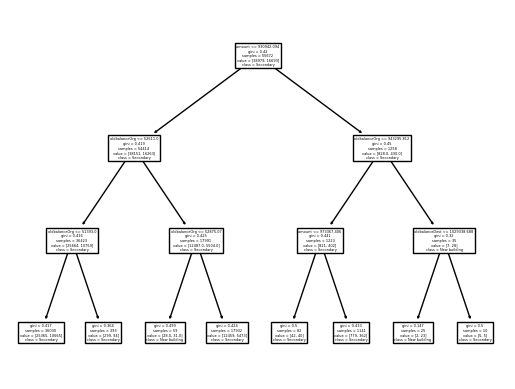

In [94]:
plot_tree(decision_tree=best_model, feature_names=x_train.columns, class_names=['Secondary','New building'])

### 7.2 Сравнения моделей на одинаковом наборе после фильтрации

In [95]:
decision_best_model_filtereds = search_filt.best_estimator_
forest_best_model_filtereds = forest_search_filt.best_estimator_
knn_best_model_filtereds = knn_search_filt.best_estimator_

In [96]:
decision_model_filtered_predict = decision_best_model_filtereds.predict(x_train_filt)
forest_model_filtered_predict = forest_best_model_filtereds.predict(x_train_forest_filt)
knn_model_filtered_predict = knn_best_model_filtereds.predict(x_train_knn_filt)

decision_model_acc = accuracy_score(y_train, decision_model_filtered_predict)
forest_model_acc = accuracy_score(y_train, forest_model_filtered_predict)
knn_model_acc = accuracy_score(y_train, knn_model_filtered_predict)

decision_model_prec = precision_score(y_train, decision_model_filtered_predict)
forest_model_prec = precision_score(y_train, forest_model_filtered_predict)
knn_model_prec = precision_score(y_train, knn_model_filtered_predict)

decision_model_rec = recall_score(y_train, decision_model_filtered_predict)
forest_model_rec = recall_score(y_train, forest_model_filtered_predict)
knn_model_rec = recall_score(y_train, knn_model_filtered_predict)

decision_model_f1 = f1_score(y_train, decision_model_filtered_predict)
forest_model_f1 = f1_score(y_train, forest_model_filtered_predict)
knn_model_f1 = f1_score(y_train, knn_model_filtered_predict)



print('-----------DECISION TREE-----------')
print(f"Accuracy: {decision_model_acc}; Precision: {decision_model_prec}; Recall: {decision_model_rec}; F1_score: {decision_model_f1}")
print('-----------RANDOM FOREST-----------')
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")
print('-----------KNN-----------')
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

-----------DECISION TREE-----------
Accuracy: 0.7003340997269722; Precision: 0.8571428571428571; Recall: 0.0007188641945725753; F1_score: 0.0014365236128568864
-----------RANDOM FOREST-----------
Accuracy: 0.7006394596924845; Precision: 1.0; Recall: 0.0016174444377882945; F1_score: 0.003229665071770335
-----------KNN-----------
Accuracy: 0.7000467021123725; Precision: 0.4375; Recall: 0.0012580123405020068; F1_score: 0.002508810704259005


### 7.3 Сравнить лучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier на тестовой выборке. Привести значения метрик.

In [97]:
best_model_pred = best_model.predict(x_test)
forest_model_predict = forest_best_model.predict(x_test)
knn_model_predict = knn_best_model.predict(x_test)


tree_model_acc = accuracy_score(y_test, best_model_pred)
tree_model_prec = precision_score(y_test, best_model_pred)
tree_model_rec = recall_score(y_test, best_model_pred)
tree_model_f1 = f1_score(y_test, best_model_pred)

forest_model_acc = accuracy_score(y_test, forest_model_predict)
forest_model_prec = precision_score(y_test, forest_model_predict)
forest_model_rec = recall_score(y_test, forest_model_predict)
forest_model_f1 = f1_score(y_test, forest_model_predict)

knn_model_acc = accuracy_score(y_test, knn_model_predict)
knn_model_prec = precision_score(y_test, knn_model_predict)
knn_model_rec = recall_score(y_test, knn_model_predict)
knn_model_f1 = f1_score(y_test, knn_model_predict)


print('-----------DECISION TREE-----------')
print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")
print('-----------RANDOM FOREST-----------')
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")
print('-----------KNN-----------')
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

-----------DECISION TREE-----------
Accuracy: 0.6996647108130762; Precision: 0.45454545454545453; Recall: 0.002094094653078319; F1_score: 0.004168982768204558
-----------RANDOM FOREST-----------
Accuracy: 0.7002095557418273; Precision: 0.9166666666666666; Recall: 0.001535669412257434; F1_score: 0.0030662020905923345
-----------KNN-----------
Accuracy: 0.6997066219614417; Precision: 0.4583333333333333; Recall: 0.001535669412257434; F1_score: 0.0030610825100876584


### можно сказать, что на тестовом наборе данных, модель "Random Forest" выдает лучше точность по сравнению с другими моделями